# pyMelt v3 - Examples - First row transition elements etc

*Simon Matthews (University of Cambridge)*

In this workbook I demonstrate how the new phaseDiagram module can be used to estimate the concentrations of FRTEs and other indicators of pyroxenite melting.

First, import required packages:

In [1]:
import pyMelt as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This should output '3.dev0', if it doesn't then you need to install the dev version before continuing.

In [2]:
m.__version__

'3.dev0'

## Outline
We are going to perform calculations in stages:
1. Define a multi-lithology mantle
2. Calculate the P-T path the mantle takes during decompression melting, and the melt fractions produced in each lithology along that path.
3. Set up information about the chemical properties of the mantle components that are melting, in particular how their mineralogy changes during melting, and their budget of trace/minor elements.
4. Calculate the composition of the instantaneous melts produced during decompression melting
5. Process the results in light of the geological setting where the melts are being produced.


## 1. Define the multi-lithology mantle

Here we will work with two components, a lherzolite and a pyroxenite. Look back at the other tutorials to see how to add in a harzburgite if you want to do that too!

In [3]:
lz = m.lithologies.matthews.klb1()
px = m.lithologies.matthews.kg1()

Next we will combine these into a mantle with 90% lherzolite:

In [4]:
mantle = m.mantle([lz, px], [0.9, 0.1], ['lz', 'px'])

## 2. Calculate decompression melting

Now we will do decompression melting at a $T_p$ of 1500˚C to make a melting column:

In [5]:
column = mantle.adiabaticMelt(1500.0, dP=-0.004)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyMelt/mantle_class.py:476: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


We can check what this calculation did by making a plot:

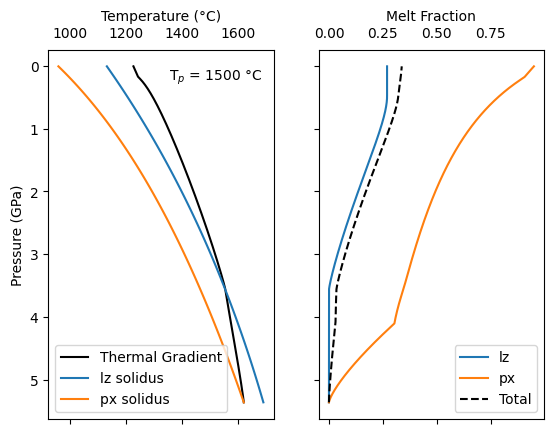

In [6]:
fig, ax = column.plot()

plt.show()

## 3. Set up chemical properties
This step is the most involved as it requires the most additional information and assumptions. To make it really clear and easy to change I am going to define every parameter here. You could also rely on pyMelt defaults or extract some of the built in data, but it might be a bit harder to track what's going on! The existing tutorial 3 draws in some of the built in data, so look there for an example.

### 3.1: Define mineralogy and major elements
The big update with pyMelt v3 is the incorporation of phase diagrams calculated using thermodynamic modelling codes. We will import the KLB1 lherzolite phase diagram calculated by THERMOCALC:

In [7]:
phasediag_klb1 = m.load_phaseDiagram('thermocalc_klb1')

We can do the same for KG1:

In [8]:
phasediag_kg1 = m.load_phaseDiagram('thermocalc_kg1')

### 3.2: Define source trace/minor element concentrations:

We need to provide the concentrations for the trace elements in each source:

In [9]:
# Workman & Hart (2005) DMM:
lz_tes = {
    "Rb": 0.05,
    "Ba": 0.563,
    "Th": 0.0079,
    "U": 0.0032,
    "Nb": 0.1485,
    "Ta": 0.0096,
    "La": 0.192,
    "Ce": 0.550,
    "Pb": 0.018,
    "Nd": 0.581,
    "Sr": 7.664,
    "Zr": 5.082,
    "Hf": 0.157,
    "Sm": 0.239,
    "Eu": 0.096,
    "Ti": 716.3,
    "Gd": 0.358,
    "Dy": 0.505,
    "Y": 3.328,
    "Er": 0.348,
    "Yb": 0.365,
    "Lu": 0.058,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# Stracke et al. (2003) recycled crust:
# These might be too high!
px_tes = {
    "Rb": 0.57,
    "Ba": 6.59,
    "Th": 0.088,
    "U": 0.027,
    "Nb": 1.95,
    "Ta": 0.124,
    "La": 1.68,
    "Ce": 5.89,
    "Pb": 0.09,
    "Nd": 7.45,
    "Sr": 81.0,
    "Zr": 64.0,
    "Hf": 1.78,
    "Sm": 2.69,
    "Eu": 1.04,
    "Ti": 7735.0,
    "Gd": 4.03,
    "Dy": 5.01,
    "Y": 28.5,
    "Er": 3.13,
    "Yb": 2.99,
    "Lu": 0.45,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

### 3.3 Define partition coefficients:
We need to provide a partition coefficient for each mineral. First we will set up the variable partition coefficients for Ni etc. To avoid writing lots of different functions we can define a general form of Matzen's equations, and adjust them so that each Kd is between a mineral and liquid (rather than a mineral and olivine):

$ \ln K_D = A + B \times MgO^{liq} + \frac{C}{T(K)} + \frac{E (\textrm{Cr#}^\textrm{sp}_\textrm{wt})}{T(K)} + F (\textrm{CaO}^\textrm{cpx})^4$


In [19]:
def matzen_D(state, Kd_A=None, Kd_B=None, Kd_C=None, 
             liq_MgO_wtpt=None, mineral_MgO_wtpt=None,
             sp_Cr2O3_wtpt=None, sp_Al2O3_wtpt=None, sp_Fe2O3_wtpt=None,
             cpx_A=2.1101e-5, cpx_B=-7.5872e-4, cpx_C=1.3204e-2, cpx_E=-0.10348, cpx_F=1.2147,
             cpx_CaO_wtpt=None,
             mineral=None, element=None, **kwargs):
    """
    Expressions from Matzen et al. (2017)
    
    Parameters
    ----------
    """
    
    # Parameters from fits by Matzen et al. (2017)
    matzen2017params = {'ol' : {'Ni': [-2.075, 0.0, 4505, 0.0]
                                'Mn': [-1.503, 0.0088, 0.0, 0.0]},
                        'opx': {'Mn': [-0.099, 0.0, -328, 0.0],
                                'Ni': [-0.241, 0.0, 1419, 0.0]},
                        'g':   {'Mn': [1.11, 0.0, -4171, 0.0],
                                'Ni': [-2.065, 0.0, 5264, 0.0]},
                        'sp':  {'Mn': [-0.161, 0.0, 0.0, -2292.2],
                                'Ni': [-1.118, 0.0, 0.0, 1722.0]},
                        'cpx': {'Ni': [-0.422, 0.0, 1773, 0.0]}
                       }
    
    # Check if liquid MgO should be looked up:
    if callable(liq_MgO_wtpt):
        liq_MgO_wtpt = liq_MgO_wtpt(state, **kwargs)
    elif liq_MgO_wtpt is None and 'phaseDiagram' in kwargs:
        liq_MgO_wtpt = kwargs['phaseDiagram']('liq_MgO_wtpt', state)
        
    # Check if mineral MgO should be looked up:
    if mineral_MgO_wtpt is None and mineral is not None:
        mineral_MgO_wtpt = kwargs['phaseDiagram'](mineral + '_MgO_wtpt', state)
        
    # If spinel, check if compositions should be extracted:
    if mineral == 'sp':
        if sp_Cr2O3_wtpt is None:
            sp_Cr2O3_wtpt = kwargs['phaseDiagram']('sp_Cr2O3_wtpt', state)
        if sp_Al2O3_wtpt is None:
            sp_Al2O3_wtpt = kwargs['phaseDiagram']('sp_Al2O3_wtpt', state)
        if sp_Fe2O3_wtpt is None:
            sp_Fe2O3_wtpt = kwargs['phaseDiagram']('sp_Fe2O3_wtpt', state)
    
    # Extract default values if not specified:
    if Kd_A is None and mineral is not None and element is not None:
        Kd_A = matzen2017params[mineral][element][0]
    if Kd_B is None and mineral is not None and element is not None:
        Kd_B = matzen2017params[mineral][element][1]
    if Kd_C is None and mineral is not None and element is not None:
        Kd_C = matzen2017params[mineral][element][2]
    
    # Do calculation!
    
    if mineral == 'cpx' and element == 'Mn':
        if cpx_CaO_wtpt is None:
            cpx_CaO_wtpt = kwargs['phaseDiagram']('cpx_CaO_wtpt', state)
            
        D = (cpx_A * cpx_CaO_wtpt**4 + cpx_B * cpx_CaO_wtpt**3 
             + cpx_C * cpx_CaO_wtpt**2 + cpx_E * cpx_CaO_wtpt + cpx_F)
    
    else:
    
        lnKd = Kd_A + Kd_B * liq_MgO_wtpt + Kd_C / (state['T'] + 273.15)

        if mineral == 'sp':
            lnKd += E * sp_Cr2O3_wtpt / (sp_Cr2O3_wtpt + sp_Al2O3_wtpt + sp_Fe2O3_wtpt) / (state['T'] + 273.15)
        
        if mineral is in ['cpx', 'opx', 'g', 'sp']:
            D_ol_min = np.exp(lnKd) * 

        D = np.exp(lnKd) * mineral_MgO_wtpt / liq_MgO_wtpt
        
        

    
    return D

In [21]:
matzen_D(pd.Series({'P':1.0, 'F':0.05, 'T':1500.0}), mineral='ol', element='Ni', phaseDiagram=phasediag_klb1)

8.184487818242768

In [13]:
# From Gibson & Geist compilation
olv_D = {
    "Rb": 0.0003,
    "Ba": 0.000005,
    "Th": 0.00005,
    "U": 0.00038,
    "Nb": 0.0005,
    "Ta": 0.0005,
    "La": 0.0005,
    "Ce": 0.0005,
    "Pb": 0.003,
    "Pr": 0.0008,
    "Nd": 0.00042,
    "Sr": 0.00004,
    "Zr": 0.0033,
    "Hf": 0.0022,
    "Sm": 0.0011,
    "Eu": 0.0016,
    "Ti": 0.015,
    "Gd": 0.0011,
    "Tb": 0.0015,
    "Dy": 0.0027,
    "Ho": 0.0016,
    "Y": 0.0099,
    "Er": 0.013,
    "Yb": 0.020,
    "Lu": 0.020,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# From Gibson & Geist compilation
opx_D = {
    "Rb": 0.0002,
    "Ba": 0.000006,
    "Th": 0.002,
    "U": 0.002,
    "Nb": 0.004,
    "Ta": 0.004,
    "La": 0.0031,
    "Ce": 0.0040,
    "Pb": 0.009,
    "Pr": 0.0048,
    "Nd": 0.01200,
    "Sr": 0.0007,
    "Zr": 0.013,
    "Hf": 0.03,
    "Sm": 0.0200,
    "Eu": 0.0130,
    "Ti": 0.086,
    "Gd": 0.0130,
    "Tb": 0.0190,
    "Dy": 0.0110,
    "Ho": 0.0065,
    "Y": 0.052,
    "Er": 0.045,
    "Yb": 0.080,
    "Lu": 0.120,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# From Gibson & Geist compilation
cpx_D = {
    "Rb": 0.0004,
    "Ba": 0.0004,
    "Th": 0.0059,
    "U": 0.0094,
    "Nb": 0.015,
    "Ta": 0.015,
    "La": 0.0490,
    "Ce": 0.0800,
    "Pb": 0.012,
    "Pr": 0.126,
    "Nd": 0.17800,
    "Sr": 0.091,
    "Zr": 0.119,
    "Hf": 0.284,
    "Sm": 0.2930,
    "Eu": 0.3350,
    "Ti": 0.350,
    "Gd": 0.3500,
    "Tb": 0.4030,
    "Dy": 0.4000,
    "Ho": 0.4270,
    "Y": 0.426,
    "Er": 0.420,
    "Yb": 0.400,
    "Lu": 0.376,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# From Gibson & Geist compilation
grt_D = {
    "Rb": 0.0002,
    "Ba": 0.00007,
    "Th": 0.009,
    "U": 0.028,
    "Nb": 0.015,
    "Ta": 0.015,
    "La": 0.0010,
    "Ce": 0.0050,
    "Pb": 0.005,
    "Pr": 0.014,
    "Nd": 0.05200,
    "Sr": 0.0007,
    "Zr": 0.270,
    "Hf": 0.400,
    "Sm": 0.2500,
    "Eu": 0.4960,
    "Ti": 0.600,
    "Gd": 0.84800,
    "Tb": 1.4770,
    "Dy": 2.2000,
    "Ho": 3.3150,
    "Y": 3.100,
    "Er": 4.400,
    "Yb": 6.600,
    "Lu": 7.100,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# alphaMELTS defaults
spn_D = {
    "Rb": 0.0001,
    "Ba": 0.0001,
    "Th": 0.0,
    "U": 0.0,
    "Nb": 0.0,
    "Ta": 0.0,
    "La": 0.0100,
    "Ce": 0.0100,
    "Pb": 0.0,
    "Pr": 0.01,
    "Nd": 0.0100,
    "Sr": 0.0,
    "Zr": 0.0,
    "Hf": 0.0,
    "Sm": 0.0100,
    "Eu": 0.0100,
    "Ti": 0.15,
    "Gd": 0.0100,
    "Tb": 0.0100,
    "Dy": 0.0100,
    "Ho": 0.0100,
    "Y": 0.01,
    "Er": 0.0100,
    "Yb": 0.0100,
    "Lu": 0.0100,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

# From Gibson & Geist compilation
plg_D = {
    "Rb": 0.03,
    "Ba": 0.33,
    "Th": 0.05,
    "U": 0.11,
    "Nb": 0.01,
    "Ta": 0.0,
    "La": 0.2700,
    "Ce": 0.200,
    "Pb": 0.36,
    "Pr": 0.17,
    "Nd": 0.1400,
    "Sr": 2.0,
    "Zr": 0.01,
    "Hf": 0.01,
    "Sm": 0.1100,
    "Eu": 0.7300,
    "Ti": 0.04,
    "Gd": 0.0660,
    "Tb": 0.0600,
    "Dy": 0.0550,
    "Ho": 0.0480,
    "Y": 0.03,
    "Er": 0.0100,
    "Yb": 0.031,
    "Lu": 0.0250,
    "Ni": 1.0, # PLACEHOLDER
    "Mn": 1.0, # PLACEHOLDER
    "Co": 1.0, # PLACEHOLDER
}

## 4. Calculate instantaneous melt concentrations:
Feed all of this info into pyMelt:

In [14]:
column.calculateChemistry(elements={'lz': lz_tes,
                                    'px': px_tes},
                          method='phase_diagram_trace',
                          phaseDiagram={'lz': phasediag_klb1,
                                        'px': phasediag_kg1},
                          D = olv_D, # Provide this to get round pyMelt bug- it won't do anything
                          olv_D = olv_D,
                          cpx_D = cpx_D,
                          opx_D = opx_D,
                          grt_D = grt_D,
                          spn_D = spn_D,
                          plg_D = plg_D,
                          # porosity = 0.0
                         )

Repeat for the major elements. This is a bit clunky at the moment, but you can ignore most of the code here beyond the first line.

In [15]:
oxides = ['MgO', 'FeO']

species_objects = []
species_objects_px = []

for ox in oxides:
    species_objects.append(m.chemistry.phaseDiagramMajorSpecies(ox, phasediag_klb1))
    species_objects_px.append(m.chemistry.phaseDiagramMajorSpecies(ox, phasediag_kg1))


column.calculateChemistry(species_objects={'lz': species_objects, 
                                           'px': species_objects_px})


## 5. Process results

We can plot instantaneous and accumulated melts. Here I will use a spreadingCentre geosettting (i.e., Iceland like). You could also use a intraPlate geosetting.

In [23]:
lithosphere_pressure = np.linspace(5, 1, 10)

accumulated_Ni = np.zeros(np.shape(lithosphere_pressure))
accumulated_Mn = np.zeros(np.shape(lithosphere_pressure))
accumulated_Co = np.zeros(np.shape(lithosphere_pressure))
accumulated_FeO = np.zeros(np.shape(lithosphere_pressure))

for i in range(len(lithosphere_pressure)):
    geosetting = m.geosettings.spreadingCentre(column, P_lithosphere=lithosphere_pressure[i], extract_melt=True)
    accumulated_Ni[i] = geosetting.chemistry.Ni
    accumulated_Mn[i] = geosetting.chemistry.Mn
    accumulated_Ni[i] = geosetting.chemistry.Ni
    accumulated_FeO[i] = geosetting.chemistry.FeO

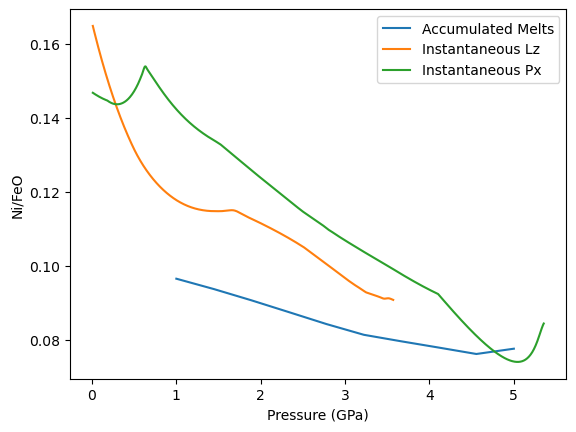

In [28]:
fig, ax = plt.subplots()

ax.plot(lithosphere_pressure, accumulated_Ni/accumulated_FeO, label='Accumulated Melts')

ax.plot(column.P, column.lithologies['lz'].Ni/column.lithologies['lz'].FeO, label='Instantaneous Lz')
ax.plot(column.P, column.lithologies['px'].Ni/column.lithologies['px'].FeO, label='Instantaneous Px')

ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('Ni/FeO')

ax.legend()

plt.show()

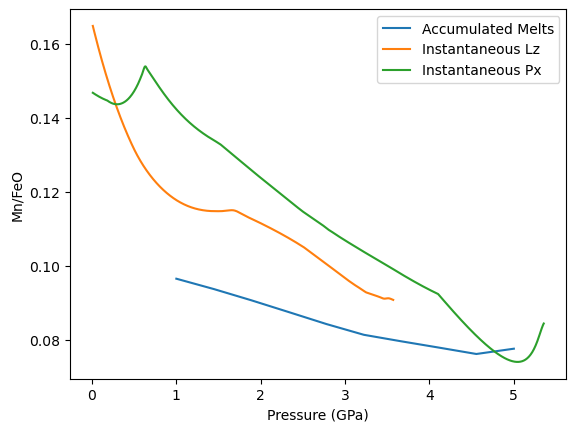

In [29]:
fig, ax = plt.subplots()

ax.plot(lithosphere_pressure, accumulated_Mn/accumulated_FeO, label='Accumulated Melts')

ax.plot(column.P, column.lithologies['lz'].Mn/column.lithologies['lz'].FeO, label='Instantaneous Lz')
ax.plot(column.P, column.lithologies['px'].Mn/column.lithologies['px'].FeO, label='Instantaneous Px')

ax.set_xlabel('Pressure (GPa)')
ax.set_ylabel('Mn/FeO')

ax.legend()

plt.show()